# Modelo para detección tweets terroristas

Durante este notebook mostrarenos los pasos implementados durante la creación del modelo y algunos análisis implementados durante la creación de este. Lo primero que realizaremos será el cargue de las librerias de python necesarias para la creación de nuestro modelo

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVR
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import RandomizedSearchCV
from sklearn import metrics
import nltk

#Esto sirve para configurar NLTK. La primera vez puede tardar un poco
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
dataset = pd.read_excel(r'C:\Users\User\Desktop\UNIR\Ciberseguridad\Trabajo Fin master\data\Dataset.xlsx')
pd.set_option('max_colwidth', 150)
dataset.head()

,Tweet,Class
0,PT announced his death. In current tweet shows his pic when he was in life in this world. #Iraq SWAT hi rank figure https://twitter.com/account/su...,1
1,The Muslim Brotherhood of #Iraq condemns the killing of Shiite militias leaders in #Diyala by the Islamic State: https://twitter.com/account/suspe...,1
2,RT @TedNugent: Gun control talks with gunrunning Eric Holder on board. We r the planet of the apes,0
3,"Come home from work to Bridesmaids, Twinkies and a bottle of wine #bestroommateever @TheFaithAnne",0
4,"RT @Ghostmanzzz: #Breaking #US airstrikes rocked #ISIS ideological Important ""#Dabiq"" Moments ago in North #Aleppo.",1


In [3]:
#Vemos el tamaño del dataset
dataset.shape

(10530, 2)

El dataset está conformado por dos columnas, la primera "tweet" con el comentario en cuestión y la segunda "class" que hace referencia al tipo de comentario a partir de la clasificación que se realizó sinendo "1" un comentario con posible contenido extremista y "0" comentario sin contenido extremista. Lo primero que queremos ver del dataset es si existe algún tipo de sesgo en la data, pero de la gráfica podemos ver que está perfectamente equilibrada la cantidad de datos por clasificación ya que tienen la misma cantidad de registros.

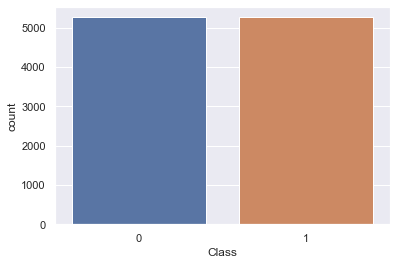

In [4]:
sns.countplot(data = dataset , x='Class')
plt.show()

#### Preparación del dasaet para llevarlo al modelo

Para el entrenamiento de nuestro modelo tomaremos solamente las columnas review body,review title y la columna stars

In [5]:
#Eliminamos registro vacíos
dataset.dropna(axis=0,inplace=True)  # Si hay alguna nan, tiramos esa instancia
dataset.head()

,Tweet,Class
0,PT announced his death. In current tweet shows his pic when he was in life in this world. #Iraq SWAT hi rank figure https://twitter.com/account/su...,1
1,The Muslim Brotherhood of #Iraq condemns the killing of Shiite militias leaders in #Diyala by the Islamic State: https://twitter.com/account/suspe...,1
2,RT @TedNugent: Gun control talks with gunrunning Eric Holder on board. We r the planet of the apes,0
3,"Come home from work to Bridesmaids, Twinkies and a bottle of wine #bestroommateever @TheFaithAnne",0
4,"RT @Ghostmanzzz: #Breaking #US airstrikes rocked #ISIS ideological Important ""#Dabiq"" Moments ago in North #Aleppo.",1


Creamos una columna nueva que es la concatenación entre reviewbody y review title para así tener una columna con más información.

In [6]:
#Cargamos los stopwprds en español
stopwords = nltk.corpus.stopwords.words('english')
print(stopwords)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [7]:
# Importamos esta libreria que nos permite reemplzar caracteres y aplicar expresiones regulares
import re
# Importamos y definimos la función que nos permite Stemmizar de nltk y definimos el stemmer
from nltk.stem import SnowballStemmer
stemmer = SnowballStemmer('english')
dataset["Tweet"].head(10)
dataset.head(10)

,Tweet,Class
0,PT announced his death. In current tweet shows his pic when he was in life in this world. #Iraq SWAT hi rank figure https://twitter.com/account/su...,1
1,The Muslim Brotherhood of #Iraq condemns the killing of Shiite militias leaders in #Diyala by the Islamic State: https://twitter.com/account/suspe...,1
2,RT @TedNugent: Gun control talks with gunrunning Eric Holder on board. We r the planet of the apes,0
3,"Come home from work to Bridesmaids, Twinkies and a bottle of wine #bestroommateever @TheFaithAnne",0
4,"RT @Ghostmanzzz: #Breaking #US airstrikes rocked #ISIS ideological Important ""#Dabiq"" Moments ago in North #Aleppo.",1
5,"Boys and girls, before the censorship bans it's been lovely talking to the and dodging all the nonsense the left has thrown out. Vote in Novemb...",0
6,"@jesslaw Ha! I'm actually going to see a Yankee game, as weird as it sounds. My uncle's house in NJ is an hour away.",0
7,Why is that when you have time off from work you get sick?,0
8,2. The Islamic State severely punishes those who systematically and routinely perform chain Takfir upon Muslims.,1
9,RT @karen_gonski: i wish i was one of those girls who guys liked no matter what...ike i could wear sweats and my hair up and they would sti&#8230;,0


In [8]:
# Importamos esta libreria que nos permite reemplzar caracteres y aplicar expresiones regulares
import re
# Importamos y definimos la función que nos permite Stemmizar de nltk y definimos el stemmer
from nltk.stem import SnowballStemmer
stemmer = SnowballStemmer('english')
# Recorremos los reviews y le vamos aplicando la Normalizacion y luega el Stemming a cada uno
review_list=[]
for review in dataset.Tweet:
     # Pasamos todo a minúsculas
    review=review.lower()
    # Filtrado de menciones de otros perfiles
    review=re.sub('(?:((?<=[\s\W])|^)[#](\w+|[^#]|$)|((?<=[\s\W])|^)[@]([a-zA-Z0-9_]+|$))', '',str(review)) 
    review=re.sub(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', '',str(review)) #Filtrado de enlaces
    revire=re.sub('\s{2}.*', '',str(review)) # filtrado de espacioes en blanco
    review=re.sub("[^a-z]"," ",str(review)) #Filtrado de caracteres especiales
    # Tokenizamos para separar las palabras del titular
    review=nltk.word_tokenize(review)
    # Sacamos las Stopwords
    review = [palabra for palabra in review if not palabra in stopwords]
    ReviewSinStemmer= review
    ## Hasta acá Normalizamos, ahora a stemmizar
    # Aplicamos la funcion para buscar la raiz de las palabras
    review=[(stemmer.stem(palabra)) for palabra in review]
    # Por ultimo volvemos a unir el tweet
    review=" ".join(review)
    ReviewSinStemmer= " ".join(ReviewSinStemmer) 
    # Vamos armando una lista con todos los titulares
    review_list.append(review)
print(review_list[:10])
    #print(review)
    #review=[palabra for palabra in review]
        # Eliminamos las palabras de menos de 2 letras
  # review = [palabra for palabra in review if len(palabra)>2]

['pt announc death current tweet show pic life world swat hi rank figur', 'muslim brotherhood condemn kill shiit militia leader islam state', 'rt gun control talk gunrun eric holder board r planet ape', 'come home work bridesmaid twinki bottl wine', 'rt airstrik rock ideolog import moment ago north', 'boy girl censorship ban love talk dodg nonsens left thrown vote novemb although voic may silenc stand', 'ha actual go see yanke game weird sound uncl hous nj hour away', 'time work get sick', 'islam state sever punish systemat routin perform chain takfir upon muslim', 'rt wish one girl guy like matter ike could wear sweat hair would sti']


 Durante el proceso de aplicar el stemmer se observó diferencias grandes entre los review sin stmmer y con stemmer al principio se pensó que estas diferencias significativas eran debido a un error pero luego de hacer la respectiva revisión de la librería del stemmer en español se encontró que internamente hace una especie de obtención de la raíz de la palabra pero de una forma no cotidiana en español, la librería tiene su propio diccionario para realizar esta operación. Comparto el enlace dónde se observó dichas diferencias http://snowball.tartarus.org/algorithms/spanish/diffs.txt


In [9]:
#diferencias entre los review con sttemer y sin setmmer
print("Sin Stemmer: ",ReviewSinStemmer)
print("Con Stemmer: ",review)
print(review_list[2093:2094])

Sin Stemmer:  personnel killed storming barracks outskirts ad dulab region
Con Stemmer:  personnel kill storm barrack outskirt ad dulab region
['laat meet uzzah plot islam']


In [10]:
#columna nueva con la stematización
dataset["review_stem"] = review_list
dataset.tail()

,Tweet,Class,review_stem
10525,"My Hawaiian thought of the day, No Aloha for muzzie pigs, EVER!",0,hawaiian thought day aloha muzzi pig ever
10526,"@ImtiyazAzhar From what I understand having spoken to ISIS supporters, Abdullah Faisal is not an ISIS representative scholar.",1,understand spoken isi support abdullah faisal isi repres scholar
10527,@AstrosCounty Jeff Luhnow is to blame for the Astros not blowing out the Red Sox and Yankees -HC,0,jeff luhnow blame astro blow red sox yanke hc
10528,@Dalatrm Pigs,0,pig
10529,#WilayatAlAnbar 15 #Rafida_army’s personnel killed after storming their barracks at the outskirts of Ad-Dulab region https://justpaste.it/u027,1,personnel kill storm barrack outskirt ad dulab region


In [11]:
Filtro= dataset['review_stem']!=""
dataset= dataset[Filtro]
dataset.dropna(axis=0,inplace=True)  # Si hay alguna nan, tiramos esa instancia
print (dataset['review_stem'])
print(dataset.shape)
dataset.tail()

0        pt announc death current tweet show pic life world swat hi rank figur
1             muslim brotherhood condemn kill shiit militia leader islam state
2                    rt gun control talk gunrun eric holder board r planet ape
3                                  come home work bridesmaid twinki bottl wine
4                             rt airstrik rock ideolog import moment ago north
                                         ...                                  
10525                                hawaiian thought day aloha muzzi pig ever
10526         understand spoken isi support abdullah faisal isi repres scholar
10527                            jeff luhnow blame astro blow red sox yanke hc
10528                                                                      pig
10529                    personnel kill storm barrack outskirt ad dulab region
Name: review_stem, Length: 10452, dtype: object
(10452, 3)


,Tweet,Class,review_stem
10525,"My Hawaiian thought of the day, No Aloha for muzzie pigs, EVER!",0,hawaiian thought day aloha muzzi pig ever
10526,"@ImtiyazAzhar From what I understand having spoken to ISIS supporters, Abdullah Faisal is not an ISIS representative scholar.",1,understand spoken isi support abdullah faisal isi repres scholar
10527,@AstrosCounty Jeff Luhnow is to blame for the Astros not blowing out the Red Sox and Yankees -HC,0,jeff luhnow blame astro blow red sox yanke hc
10528,@Dalatrm Pigs,0,pig
10529,#WilayatAlAnbar 15 #Rafida_army’s personnel killed after storming their barracks at the outskirts of Ad-Dulab region https://justpaste.it/u027,1,personnel kill storm barrack outskirt ad dulab region


In [12]:
#Conversión a lista de la columna stematizada
list_review_stem = list(dataset['review_stem'].values)
#nos quedamos con el array de los valores de la califación
Calification = dataset['Class'].values

Vampos a vectorizar utilizando la función CountVectorizer y el TfidfVectorizer de ScikitLearn la cual creará un vector a partir de la frecuencia de cada palabra en el texto. En el proyecto 3 se planteó como una posibilidad de mejorael uso de TfidfVectorizer veremos si efectivamente tiene efectos signficativos

In [13]:
#TfidfVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
# Usaremos solo 5000 features
max_features=500

# Es decir que cada instancia tendrá 1000 features
Tfidf_vec=TfidfVectorizer(max_features=max_features) 

#Le pasamos nuestra lista de palabras al objeto cou_vec
matriz_reviews_Tfidf= Tfidf_vec.fit_transform(list_review_stem)
# Tomamos las palabras
all_words = Tfidf_vec.get_feature_names()
# Vizualizamos 50 de las palabras mas usadas
print("50 palabras mas usadas: ",all_words[0:50])

50 palabras mas usadas:  ['abu', 'abus', 'accept', 'account', 'actual', 'advanc', 'ago', 'ahrar', 'air', 'airbas', 'airport', 'airstrik', 'al', 'aleppo', 'allah', 'alli', 'also', 'alway', 'ambush', 'america', 'american', 'amp', 'anoth', 'anti', 'anyon', 'anyth', 'apost', 'arab', 'area', 'arm', 'armi', 'around', 'arrest', 'ask', 'assad', 'assault', 'attack', 'attempt', 'away', 'babi', 'back', 'bad', 'baghdad', 'barrack', 'base', 'battl', 'beauti', 'becom', 'bed', 'believ']


## Modelos con TfidfVectorizer

In [14]:
#pasamos de matriz a array la variable matriz_reviews
x = matriz_reviews_Tfidf.toarray()
y = Calification

#Hacemos la separación en data entrenamiento y pruebas
xtrain, xtest, ytrain, ytest = train_test_split(x,y,test_size=0.3,random_state=42,stratify=y)

In [15]:
#Aplicamos un modelo de bayes simple

nb = GaussianNB()
nb.fit(xtrain,ytrain)
y_predTrain=nb.predict(xtrain)
y_pred=nb.predict(xtest)
#---------Train----------
F1_Score_NBTrain= f1_score(ytrain, y_predTrain, average='macro')
print("F1 Score NB Train= ",F1_Score_NBTrain)
#---------Test----------
F1_Score_NBTEST= f1_score(ytest, y_pred, average='macro')
print("F1 Score NB TEST= ",F1_Score_NBTEST)


F1 Score NB Train=  0.8699726868055913
F1 Score NB TEST=  0.8651729559748428


In [16]:
#Aplicamos un modelo de Random forest con parámetros por defecto

rf = RandomForestClassifier(n_estimators = 10, random_state=42)
rf.fit(xtrain,ytrain)
y_predTrain=rf.predict(xtrain)
y_pred=rf.predict(xtest)
#---------Train----------
F1_Score_forestTrain= f1_score(ytrain, y_predTrain, average='macro')
print("F1 Score NB Train= ",F1_Score_forestTrain)
#---------Test----------
F1_Score_forestTEST= f1_score(ytest, y_pred, average='macro')
print("F1 Score NB TEST= ",F1_Score_forestTEST)

F1 Score NB Train=  0.9706055899910178
F1 Score NB TEST=  0.8845661387282295


In [17]:
#Aplicamos un modelo de svc con parámetros por defecto
# Notar que en vez de utilizar SVC, vamos a usar LinearSVC. 
# esta función es MUCHO mas rapida que la tradicional SVC.

svc = LinearSVC(C = 1,max_iter=1000)
svc.fit(xtrain,ytrain)
y_predTrain=svc.predict(xtrain)
y_pred=svc.predict(xtest)
#---------Train----------
F1_Score_svcTrain= f1_score(ytrain, y_predTrain, average='macro')
print("F1 Score NB Train= ",F1_Score_svcTrain)
#---------Test----------
F1_Score_svcTEST= f1_score(ytest, y_pred, average='macro')
print("F1 Score NB TEST= ",F1_Score_svcTEST)

F1 Score NB Train=  0.9108696048631311
F1 Score NB TEST=  0.8937899188662821


## Resultados Countvectorizer vs TfIdf


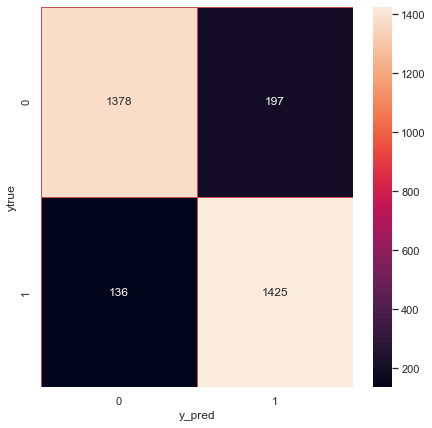

In [18]:


def confusion(ytest,y_pred):
    names=["0","1"]
    cm=confusion_matrix(ytest,y_pred)
    f,ax=plt.subplots(figsize=(7,7))
    sns.heatmap(cm,annot=True,linewidth=.5,linecolor="r",fmt=".0f",ax=ax)
    plt.xlabel("y_pred")
    plt.ylabel("ytrue")
    ax.set_xticklabels(names)
    ax.set_yticklabels(names)
    plt.show()

    return
confusion(ytest,y_pred)


Imprimimos la matriz de confusión y vemos que tiene una diagonal con valores altos lo que significa que logra predecir buena cantidad de los valores reales, pero adicional vemos que los valores extemos (1,5) son los que presentan mejor comportamiento. Cómo era de esperarse alrededor del 3 hay gran variabilidad porque puede que el modelo lo tome como un 2 o un 4 y no como el 3.

Conclusiones

Con modelos de clasificación Se intentó evaluar 3 modelos básicos bayes(benchmark), random forest y SVC. se vió que el random forest y el SVC lograron mejores resultados que el modelo benchmark era de esperarse ya que son modelos más complejos. Entre SVC y random forest se elige el SVC ya que se ejecutó más rápido y además presentó mejores resultados de f1score que fue la métrica para la evaluación de los modelos

Como conclusión tanto con un modelo de clasificación como con un modelo de regresión se pudo crear un modelo de una máquina de soporte vectorial que puede decir el número de estrellas que puede tener un comentario a partir del titulo y el body del review, pero arrojó resultados más optimos el modelo de regresión.

El modelo de regresión tuvo un mejor comportamiento que el modelo de clasificación ya que aqui importa el orden de los registro y en la clasificación no, además el error que se obtuvo fue de aproximadamente 1 en el RMSE lo cual dice que es muy poco probable que una review calificada en 1 el modelo de una predicción de 5. lo cual también se puede observar en la matriz de confusión anterior

Como trabajo a futuro se podría pensar en crear modelos con redes neuronales que la literatura menciona como los modelos más indicados para el trabajo con NLP

El proyecto puede verse también en mi github https://github.com/juanbetancur96/AmazonNLP


In [19]:
print(y_pred)

[0 1 1 ... 0 1 0]


In [20]:
Lines = "We will destroy you in our kuffar, you should wait for our revenge"
Tfidf_vec.input(Lines)

TypeError: 'str' object is not callable

In [ ]:


print(type(Tfidf_vec))
analyzer= Tfidf_vec.build_tokenizer()
y=analyzer("We will destroy you in our kuffar, you should wait for our revenge")
print(y)
Tfidf_vec.input(y)
#docs = Tfidf_vec(Lines)
#docs = Tfidf_vec.norm(Lines)
#print(docs)
#type (docs)
#scores, _ = svc.predict(docs)
#Prob score for both classes (Good/bad) 


In [23]:
dataset2 = pd.read_excel(r'C:\Users\User\Desktop\UNIR\Ciberseguridad\Trabajo Fin master\data\Prueba.xlsx')
import re
# Importamos y definimos la función que nos permite Stemmizar de nltk y definimos el stemmer
from nltk.stem import SnowballStemmer
stemmer = SnowballStemmer('english')
# Recorremos los reviews y le vamos aplicando la Normalizacion y luega el Stemming a cada uno
review_list2=[]
for review in dataset2.Tweet:
     # Pasamos todo a minúsculas
    review=review.lower()
    # Filtrado de menciones de otros perfiles
    review=re.sub('(?:((?<=[\s\W])|^)[#](\w+|[^#]|$)|((?<=[\s\W])|^)[@]([a-zA-Z0-9_]+|$))', '',str(review)) 
    review=re.sub(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', '',str(review)) #Filtrado de enlaces
    revire=re.sub('\s{2}.*', '',str(review)) # filtrado de espacioes en blanco
    review=re.sub("[^a-z]"," ",str(review)) #Filtrado de caracteres especiales
    # Tokenizamos para separar las palabras del titular
    review=nltk.word_tokenize(review)
    # Sacamos las Stopwords
    review = [palabra for palabra in review if not palabra in stopwords]
    ReviewSinStemmer= review
    ## Hasta acá Normalizamos, ahora a stemmizar
    # Aplicamos la funcion para buscar la raiz de las palabras
    review=[(stemmer.stem(palabra)) for palabra in review]
    # Por ultimo volvemos a unir el tweet
    review=" ".join(review)
    ReviewSinStemmer= " ".join(ReviewSinStemmer) 
    # Vamos armando una lista con todos los titulares
    review_list2.append(review)
#print(review_list2[:])

dataset2["review_stem"] = review_list2
listica = list(dataset2['review_stem'].values)
listica2= Tfidf_vec.transform(listica)
Prueba=nb.predict(listica2.toarray())
for i in Prueba:
    print (Prueba[i])

0
1
1
0
0
1
1
0
0
1
0
0
1
0
0
1
0
0
1
1
0
1
1
